# HW 3 - Neural POS Tagger

In this exercise, you are going to build a set of deep learning models on part-of-speech (POS) tagging using Tensorflow 2. Tensorflow is a deep learning framwork developed by Google to provide an easier way to use standard layers and networks.

To complete this exercise, you will need to build deep learning models for POS tagging in Thai using NECTEC's ORCHID corpus. You will build one model for each of the following type:

- Neural POS Tagging with Word Embedding using Fixed / non-Fixed Pretrained weights
- Neural POS Tagging with Viterbi / Marginal CRF

Pretrained word embeddding are already given for you to use (albeit, a very bad one).

We also provide the code for data cleaning, preprocessing and some starter code for tensorflow 2 in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

### Don't forget to change hardware accelrator to GPU in runtime on Google Colab ###

## 1. Setup and Preprocessing

We use POS data from [ORCHID corpus](https://www.nectec.or.th/corpus/index.php?league=pm), which is a POS corpus for Thai language.
A method used to read the corpus into a list of sentences with (word, POS) pairs have been implemented already. The example usage has shown below.
We also create a word vector for unknown word by random.

In [1]:
import os    
import numpy as np
import numpy.random
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd

from resources.embeddings.emb_reader import get_embeddings
from IPython.display import display
from resources.data.orchid_corpus import get_sentences
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense,GRU,Reshape,TimeDistributed,Bidirectional,Dropout,Masking
from keras.optimizers import Adam
from keras import backend as K
from tf2crf import CRF, ModelWithCRFLoss, ModelWithCRFLossDSCLoss                                                             
from modelConfig import POSConfig
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import load_model
from sklearn.model_selection import train_test_split

np.random.seed(42)

In [2]:
yunk_emb =np.random.randn(32)
train_data = get_sentences('train')
test_data = get_sentences('test')
print(train_data[0])

[('การ', 'FIXN'), ('ประชุม', 'VACT'), ('ทาง', 'NCMN'), ('วิชาการ', 'NCMN'), ('<space>', 'PUNC'), ('ครั้ง', 'CFQC'), ('ที่ 1', 'DONM')]


In [3]:
yunk_emb

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004,
       -0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
       -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ,
        1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272,
        0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375,
       -0.60170661,  1.85227818])

Next, we load pretrained weight embedding using pickle. The pretrained weight is a dictionary which map a word to its embedding.

In [4]:
import pickle
fp = open('resources/basic_ff_embedding.pt', 'rb')
embeddings = pickle.load(fp)
fp.close()

In [5]:
embeddings

{'พุทธเจ้าพระองค์': array([-0.01917224, -0.00415204, -0.02412283, -0.04142096,  0.04691369,
         0.03376952, -0.00270034, -0.04676848,  0.03299177,  0.03790374,
         0.0432213 , -0.01537431, -0.02517369, -0.04052844, -0.01157572,
         0.00185845, -0.00034374,  0.03099574, -0.00553056,  0.03075998,
        -0.02743803, -0.03812069, -0.02771009, -0.00890391, -0.03464903,
        -0.03346384, -0.04095409,  0.03574741,  0.04473687,  0.0170097 ,
        -0.00490531,  0.01063981], dtype=float32),
 'จุ๊บุ': array([ 0.02896592,  0.02110482,  0.03715003,  0.02296479, -0.03441135,
         0.03496312,  0.03625641, -0.02355627, -0.03617386,  0.01206947,
         0.02429886, -0.02565069, -0.02642049, -0.03778682, -0.00951525,
        -0.0446926 , -0.02631601,  0.04875654,  0.04526813,  0.0079442 ,
         0.0340622 ,  0.00625456,  0.01675535,  0.01817935, -0.03839616,
        -0.04811118,  0.03423071,  0.015117  ,  0.00746933,  0.02313724,
         0.01740095,  0.02209598], dtype=floa

The given code below generates an indexed dataset(each word is represented by a number) for training and testing data. The index 0 is reserved for padding to help with variable length sequence. (Additionally, You can read more about padding here [https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/])

## 2. Prepare Data

In [6]:
word_to_idx ={}
idx_to_word ={}
label_to_idx = {}
for sentence in train_data:
    for word,pos in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)+1
            idx_to_word[word_to_idx[word]] = word
        if pos not in label_to_idx:
            label_to_idx[pos] = len(label_to_idx)+1
word_to_idx['UNK'] = len(word_to_idx)

n_classes = len(label_to_idx.keys())+1

In [7]:
n_classes

48

This section is tweaked a little from the demo, word2features will return word index instead of features, and sent2labels will return a sequence of word indices in the sentence.

In [8]:
def word2features(sent, i, emb):
    word = sent[i][0]
    if word in word_to_idx :
        return word_to_idx[word]
    else :
        return word_to_idx['UNK']

def sent2features(sent, emb_dict):
    return np.asarray([word2features(sent, i, emb_dict) for i in range(len(sent))])

def sent2labels(sent):
    return np.asarray([label_to_idx[label] for (word, label) in sent],dtype='int32')

def sent2tokens(sent):
    return [word for (word, label) in sent]

In [9]:
sent2features(train_data[100], embeddings)

array([ 29, 327,   5, 328])

Next we create train and test dataset, then we use tensorflow 2 to post-pad the sequence to max sequence with 0. Our labels are changed to a one-hot vector.

In [10]:
# %%time
# x_train = np.asarray([sent2features(sent, embeddings) for sent in train_data])
# y_train = [sent2labels(sent) for sent in train_data]
# x_test = [sent2features(sent, embeddings) for sent in test_data]
# y_test = [sent2labels(sent) for sent in test_data]

# We encounter an error in x_train so we modified it to this following code.

x_train =  [sent2features(sent, embeddings) for sent in train_data]
y_train =  [sent2labels(sent) for sent in train_data]
x_test = [sent2features(sent, embeddings) for sent in test_data]
y_test =  [sent2labels(sent) for sent in test_data]

In [11]:
x_train=tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
y_train_pad=tf.keras.preprocessing.sequence.pad_sequences(y_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
x_test=tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=102, dtype='int32', padding='post', truncating='pre', value=0.)
y_test_pad=tf.keras.preprocessing.sequence.pad_sequences(y_test, maxlen=102, dtype='int32', padding='post', truncating='pre', value=0.)
y_temp =[]
for i in range(len(y_train_pad)):
    y_temp.append(np.eye(n_classes)[y_train_pad[i]][np.newaxis,:])
y_train = np.asarray(y_temp).reshape(-1,102,n_classes)
del(y_temp)

In [12]:
print(x_train[100],x_train.shape)
print(y_train[100][3],y_train.shape)

[ 29 327   5 328   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] (18500, 102)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] (18500, 102, 48)


In [13]:
print(x_test[100],x_test.shape)
print(y_test[100])

[1324  430  324    5  325    5 1327    5 1328    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0] (4625, 102)
[11 11 10  4 10  4 10  4 10]


## 3. Evaluate

Our output from tf keras is a distribution of problabilities on all possible label. outputToLabel will return an indices of maximum problability from output sequence.

evaluation_report is the same as in the demo

In [14]:
def outputToLabel(yt,seq_len):
    out = []
    for i in range(0,len(yt)):
        if(i==seq_len):
            break
        out.append(np.argmax(yt[i]))
    return out

In [15]:
def evaluation_report(y_true, y_pred):
    # retrieve all tags in y_true
    tag_set = set()
    for sent in y_true:
        for tag in sent:
            tag_set.add(tag)
    for sent in y_pred:
        for tag in sent:
            tag_set.add(tag)
    tag_list = sorted(list(tag_set))
    
    # count correct points
    tag_info = dict()
    for tag in tag_list:
        tag_info[tag] = {'correct_tagged': 0, 'y_true': 0, 'y_pred': 0}

    all_correct = 0
    all_count = sum([len(sent) for sent in y_true])
    for sent_true, sent_pred in zip(y_true, y_pred):
        for tag_true, tag_pred in zip(sent_true, sent_pred):
            if tag_true == tag_pred:
                tag_info[tag_true]['correct_tagged'] += 1
                all_correct += 1
            tag_info[tag_true]['y_true'] += 1
            tag_info[tag_pred]['y_pred'] += 1
    accuracy = (all_correct / all_count) * 100
            
    # summarize and make evaluation result
    eval_list = list()
    for tag in tag_list:
        eval_result = dict()
        eval_result['tag'] = tag
        eval_result['correct_count'] = tag_info[tag]['correct_tagged']
        precision = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_pred'])*100 if tag_info[tag]['y_pred'] else '-'
        recall = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_true'])*100 if (tag_info[tag]['y_true'] > 0) else 0
        eval_result['precision'] = precision
        eval_result['recall'] = recall
        eval_result['f_score'] = (2*precision*recall)/(precision+recall) if (type(precision) is float and recall > 0) else '-'
        
        eval_list.append(eval_result)

    eval_list.append({'tag': 'accuracy=%.2f' % accuracy, 'correct_count': '', 'precision': '', 'recall': '', 'f_score': ''})
    
    df = pd.DataFrame.from_dict(eval_list)
    df = df[['tag', 'precision', 'recall', 'f_score', 'correct_count']]
    display(df)
    return df

## 4. Train a model

The model is this section is separated to two groups

- Neural POS Tagger (4.1)
- Neural CRF POS Tagger (4.2)

In [16]:
def model_train(x_train,y_train,model,config,retrain=False):

    sub_path = config.log_path + '/'+ model.name
    model_path = sub_path + '/'+ model.name
    log_dir = sub_path + '/Graph/ff'

    callbacks_list = [   
        TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=False),
        ModelCheckpoint(
            model_path,
            save_best_only=True,
            save_weights_only=True,
            monitor=config.monitor,
            mode='min',
            verbose=1
        )]
    
    x, x_val, y, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    
    if os.path.exists(model_path) and retrain:
        print(f'Model({model.name}) already exists. Loading model from file')
        print('Proceeding to retrain model')
        his = model.fit(x,y=y, batch_size=config.batch_size,epochs=config.epochs,verbose=1,callbacks=callbacks_list,validation_data=(x_val,y_val))
    elif os.path.exists(model_path) and not retrain:
        print(f'Model({model.name}) already exists. Loading model from file')
        return None
    else:
        print(f'Model({model.name}) does not exist. Training new model')
        his = model.fit(x,y=y, batch_size=config.batch_size,epochs=config.epochs,verbose=1,callbacks=callbacks_list,validation_data=(x_val,y_val))
        print('Model trained')

    model.save(model_path)
    return his

## Prediction Function

To get y_pred from the model.

In [17]:
def get_y_pred(model,x_test):
    y_temp = model.predict(x_test)
    y_pred = []
    for data in y_temp:
        temp = np.array([])
        for tag in data:
            if tag == 0:
                break
            temp = np.append(temp,tag)
        y_pred.append(temp)
    return y_pred

## 4.1 Neural POS Tagger  (Example)

We create a simple Neural POS Tagger as an example for you. This model dosen't use any pretrained word embbeding so it need to use Embedding layer to train the word embedding from scratch.

Instead of using tensorflow.keras.models.Sequential, we use tensorflow.keras.models.Model. The latter is better as it can have multiple input/output, of which Sequential model could not. Due to this reason, the Model class is widely used for building a complex deep learning model.

In [18]:
print(f'x_train shape: {x_train.shape} and y_train shape: {y_train_pad.shape}')
print(f'x_test shape: {x_test.shape} and y_test shape: {y_test_pad.shape}')
print(f'Number of classes: {n_classes}')
print(f'Number of words: {len(word_to_idx)}')
print(f'Example of x_train: {x_train[0]}')
print(f'Example of y_train: {y_train_pad[0]}')
print(f'Example of x_test: {x_test[0]}')
print(f'Example of y_test: {y_test_pad[0]}')

x_train shape: (18500, 102) and y_train shape: (18500, 102)
x_test shape: (4625, 102) and y_test shape: (4625, 102)
Number of classes: 48
Number of words: 15019
Example of x_train: [1 2 3 4 5 6 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Example of y_train: [1 2 3 3 4 5 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Example of x_test: [ 540  454    1  406 3462 1009    5 3462 1009  190    5 4322   63  566
 1805  517    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    

In [19]:
def NPOSmodel(name='NeuralPOSTagger'):
    inputs = Input(shape=(102,), dtype='int32')
    output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True))(inputs)
    output = Bidirectional(GRU(32, return_sequences=True))(output)
    output = Dropout(0.2)(output)
    output = TimeDistributed(Dense(n_classes,activation='softmax'))(output)
    model = Model(inputs, output, name=name)
    model.compile(optimizer=Adam(learning_rate=0.001),  loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.summary()
    return model

In [20]:
K.clear_session()

npos_model = NPOSmodel()
config = POSConfig()
config.monitor = 'val_loss'

his_npos = model_train(x_train,y_train,npos_model,config,retrain=False)

Model: "NeuralPOSTagger"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 102)]             0         
                                                                 
 embedding (Embedding)       (None, 102, 32)           480608    
                                                                 
 bidirectional (Bidirectiona  (None, 102, 64)          12672     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 102, 64)           0         
                                                                 
 time_distributed (TimeDistr  (None, 102, 48)          3120      
 ibuted)                                                         
                                                                 
Total params: 496,400
Trainable params: 496,400
Non

### **Tensorboard**

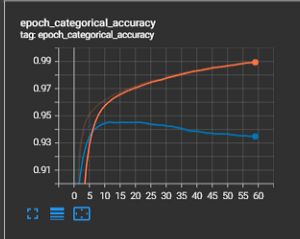

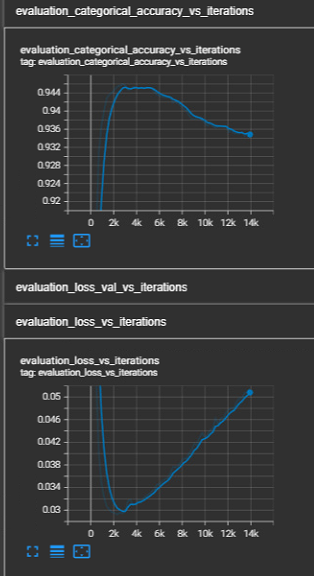

จากการพิจารณา Tensorboard จะเห็นว่าเมื่อ Epochs มากกว่า 10 จะทำให้ค่า accuracy ของ train และ validate มีความแตกต่างกันมาก และเมื่อ Epochs มากกว่า 20 จะทำให้ค่า accuracy ของ train มีค่าสูงกว่า validate อย่างมาก ซึ่งเป็นการ overfitting ทำให้ model ไม่สามารถทำนายค่าให้ถูกต้องได้

In [21]:
K.clear_session()

npos_model_10 = NPOSmodel(name='NeuralPOSTagger_10')
config = POSConfig()
config.monitor = 'val_loss'
config.epochs = 10

his_npos = model_train(x_train,y_train,npos_model_10,config,retrain=False)

Model: "NeuralPOSTagger_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 102)]             0         
                                                                 
 embedding (Embedding)       (None, 102, 32)           480608    
                                                                 
 bidirectional (Bidirectiona  (None, 102, 64)          12672     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 102, 64)           0         
                                                                 
 time_distributed (TimeDistr  (None, 102, 48)          3120      
 ibuted)                                                         
                                                                 
Total params: 496,400
Trainable params: 496,400


### **Tensorboard**

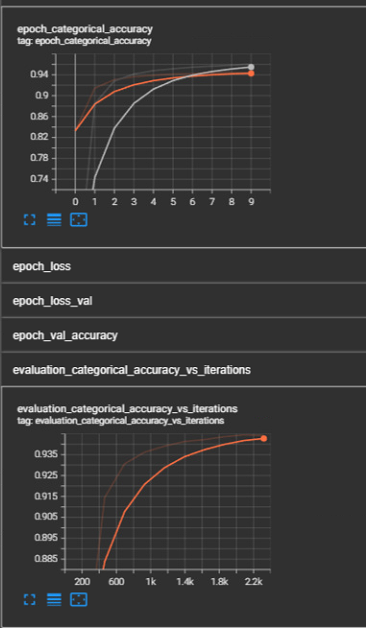

เมื่อปรับจำนวน Epochs ให้น้อยลง จะเห็นว่าค่า accuracy ของ train และ validate มีความแตกต่างกันน้อยลง

### **Load Model**

In [22]:
npos_model = load_model("tf_logs/POS/NeuralPOSTagger_10/NeuralPOSTagger_10")

### **Model Prediction**

In [23]:
y_pred= npos_model.predict(x_test)
ypred = [outputToLabel(y_pred[i],len(y_test[i])) for i in range(len(y_pred))]
df_npos = evaluation_report(y_test, ypred)               

145/145 [==============================] - 4s 6ms/step


,tag,precision,recall,f_score,correct_count
0,1,99.891127,99.592944,99.741813,3670
1,2,93.411821,95.235209,94.314703,7855
2,3,91.337421,95.26911,93.261846,16090
3,4,99.984464,99.605324,99.794534,12871
4,5,88.0,98.507463,92.957746,66
5,6,99.781659,87.547893,93.265306,457
6,7,97.722868,97.017797,97.369056,2017
7,8,59.852217,58.554217,59.196102,243
8,9,76.510067,61.956522,68.468468,228
9,10,61.862917,41.954708,50.0,352


In [24]:
print(f'x_train shape: {x_train.shape} and y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape} and y_test shape: ({len(y_test)},{len(y_test[0])})')

x_train shape: (18500, 102) and y_train shape: (18500, 102, 48)
x_test shape: (4625, 102) and y_test shape: (4625,16)


### **TensorBoard Observation**

In [25]:
# %load_ext tensorboard
# %tensorboard --logdir='tf_logs'

## 4.2 CRF Viterbi

Your next task is to incorporate Conditional random fields (CRF) to your model.

To use the CRF layer, you need to use an extension repository for tensorflow library, call tf2crf. If you want to see the detailed implementation, you should read the official tensorflow extention of CRF (https://www.tensorflow.org/addons/api_docs/python/tfa/text).

tf2crf link :  https://github.com/xuxingya/tf2crf

For inference, you should look at crf.py at the method call and view the input/output argmunets. 
Link : https://github.com/xuxingya/tf2crf/blob/master/tf2crf/crf.py



### 4.2.1 CRF without pretrained weight
### **TODO 1**
Incoperate CRF layer to your model in 4.1. CRF is quite complex compare to previous example model, so you should train it with more epoch, so it can converge.

To finish this excercise you must train the model and show the evaluation report with this model as shown in the example.

Do not forget to save this model weight.

In [26]:
# INSERT YOUR CODE HERE
def PosTagwithCRF(name='POSTaggerwithCRF'):
    inputs = Input(shape=(102,), dtype='int32', name='inputLayer')
    output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True,name='EmbeddingLayer'))(inputs)
    output = Bidirectional(GRU(32, return_sequences=True),name="BidirectionalLayer")(output)
    output = Dropout(0.2,name="DropoutLayer")(output)
    output = TimeDistributed(Dense(n_classes,activation='softmax'),name="TimeDistributedLayer")(output)
    
    crf = CRF(n_classes, dtype='float32',name="CRFLayer")
    output = crf(output)
    base_model = Model(inputs, output, name=name)
    base_model.summary()
    
    model = ModelWithCRFLoss(base_model, sparse_target=True)
    model.compile(optimizer=Adam(learning_rate=0.001))
    model._name = name
    return model

In [27]:
K.clear_session()

model_POS_CRF = PosTagwithCRF()
config = POSConfig()
config.epochs = 80

his_pos_crf = model_train(x_train,y_train_pad,model_POS_CRF,config,retrain=False)

Model: "POSTaggerwithCRF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 102)]             0         
                                                                 
 EmbeddingLayer (Embedding)  (None, 102, 32)           480608    
                                                                 
 BidirectionalLayer (Bidirec  (None, 102, 64)          12672     
 tional)                                                         
                                                                 
 DropoutLayer (Dropout)      (None, 102, 64)           0         
                                                                 
 TimeDistributedLayer (TimeD  (None, 102, 48)          3120      
 istributed)                                                     
                                                                 
 CRFLayer (CRF)              ((None, 102),        

### **TensorBoard Observation**

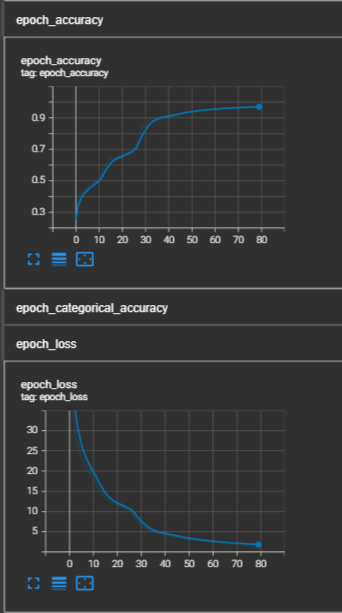

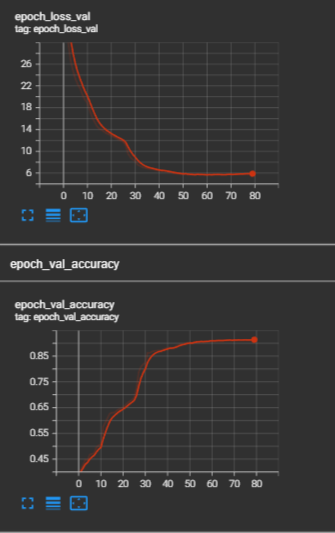

จากผลลัพธ์ที่ได้จาก tensorboard ของการทำ PoS with CRF พบว่าค่า loss ที่ 60 epoches มีลักษณะเข้าใกล้ค่าคงที่เเล้ว เเละกราฟ loss ของ train กับ validate มีความคล้ายคลึงกัน คือลดลงเเละไม่เพิ่มขึ้น แสดงว่า model นี้เป็น Good Fitting (Ref. https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/)

### **Try tanh activation function**

In [28]:
# INSERT YOUR CODE HERE
def PosTagwithCRF_tanh(name='POSTaggerwithCRF_tanh'):
    inputs = Input(shape=(102,), dtype='int32', name='inputLayer')
    output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True,name='EmbeddingLayer'))(inputs)
    output = Bidirectional(GRU(32, return_sequences=True),name="BidirectionalLayer")(output)
    output = Dropout(0.2,name="DropoutLayer")(output)
    output = TimeDistributed(Dense(n_classes,activation='tanh'),name="TimeDistributedLayer")(output)
    
    crf = CRF(n_classes, dtype='float32',name="CRFLayer")
    output = crf(output)
    base_model = Model(inputs, output, name=name)
    base_model.summary()
    
    model = ModelWithCRFLoss(base_model, sparse_target=True)
    model.compile(optimizer=Adam(learning_rate=0.001))
    model._name = name
    return model

In [29]:
K.clear_session()

model_POS_CRF = PosTagwithCRF_tanh("POSTaggerwithCRF_tanh")
config = POSConfig()
config.epochs = 40

his_pos_crf = model_train(x_train,y_train_pad,model_POS_CRF,config,retrain=False)

Model: "POSTaggerwithCRF_tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 102)]             0         
                                                                 
 EmbeddingLayer (Embedding)  (None, 102, 32)           480608    
                                                                 
 BidirectionalLayer (Bidirec  (None, 102, 64)          12672     
 tional)                                                         
                                                                 
 DropoutLayer (Dropout)      (None, 102, 64)           0         
                                                                 
 TimeDistributedLayer (TimeD  (None, 102, 48)          3120      
 istributed)                                                     
                                                                 
 CRFLayer (CRF)              ((None, 102),   

### **TensorBoard Observation**

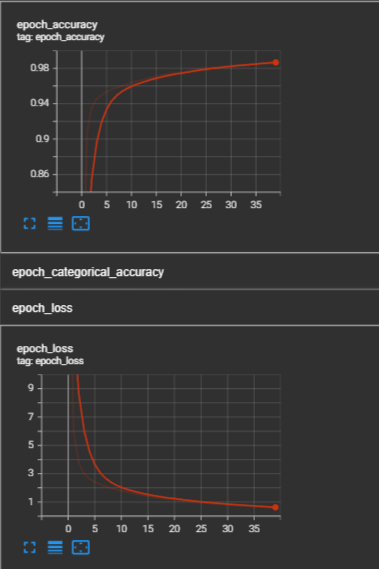

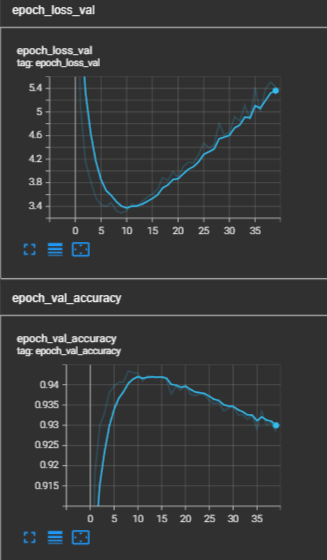

จากการสังเกตพบว่าเมื่อเกินช่วง 10 epoch จะทำให้ loss ของ train มีค่าต่างกับ validate อย่างมาก ซึ่งเป็นการ overfitting ทำให้ model ไม่สามารถทำนายค่าให้ถูกต้องได้

In [30]:
K.clear_session()

model_POS_CRF = PosTagwithCRF_tanh("POSTaggerwithCRF_tanh_10")
config = POSConfig()
config.epochs = 10

his_pos_crf = model_train(x_train,y_train_pad,model_POS_CRF,config,retrain=False)

Model: "POSTaggerwithCRF_tanh_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 102)]             0         
                                                                 
 EmbeddingLayer (Embedding)  (None, 102, 32)           480608    
                                                                 
 BidirectionalLayer (Bidirec  (None, 102, 64)          12672     
 tional)                                                         
                                                                 
 DropoutLayer (Dropout)      (None, 102, 64)           0         
                                                                 
 TimeDistributedLayer (TimeD  (None, 102, 48)          3120      
 istributed)                                                     
                                                                 
 CRFLayer (CRF)              ((None, 102),

### **TensorBoard Observation**

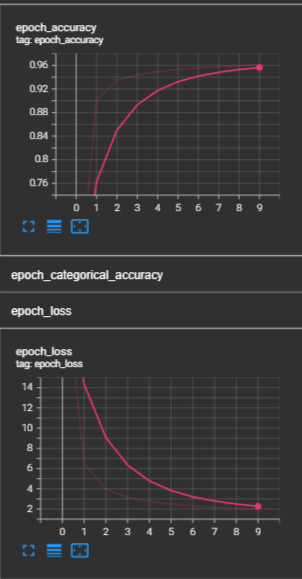

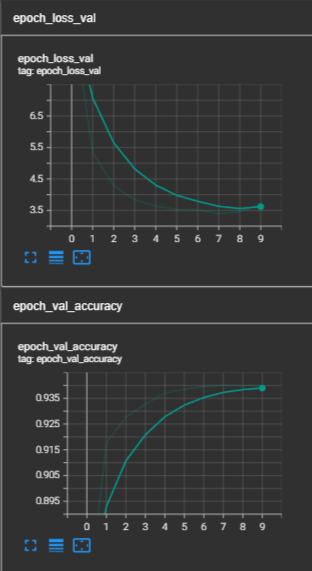

จะเห็นได้ว่าเมื่อเกินช่วง 10 epoch จะทำให้ loss ของ train กับ validate มีค่าไม่กันมาก

### **Load Model**

In [31]:
model_POS_CRF = load_model("tf_logs/POS/POSTaggerwithCRF_tanh_10/POSTaggerwithCRF_tanh_10")

### **Model Prediction**

In [32]:
his_pos_crf_pred = get_y_pred(model_POS_CRF,x_test)
df_his_pos_crf = evaluation_report(y_test, his_pos_crf_pred)

145/145 [==============================] - 19s 124ms/step


,tag,precision,recall,f_score,correct_count
0,1,99.863946,99.592944,99.728261,3670
1,2,93.559928,95.113967,94.330548,7845
2,3,91.035644,96.027,93.46473,16218
3,4,99.868064,99.582108,99.724881,12868
4,5,95.652174,98.507463,97.058824,66
5,6,99.56427,87.547893,93.170234,457
6,7,97.220891,97.594998,97.407585,2029
7,8,61.038961,56.626506,58.75,235
8,9,74.832215,60.597826,66.966967,223
9,10,61.929825,42.073897,50.106458,353



### 4.2.2 CRF with pretrained weight

### **TODO 2**

We would like you create a neural CRF POS tagger model  with the pretrained word embedding as an input and the word embedding is trainable (not fixed). To finish this excercise you must train the model and show the evaluation report with this model as shown in the example.

Please note that the given pretrained word embedding only have weights for the vocabuary in BEST corpus.

You can read more information about using predtained weight in embedding layer on Keras from the following link:

https://keras.io/examples/nlp/pretrained_word_embeddings/

Optionally, you can use your own pretrained word embedding.

#### Hint: You can get the embedding from get_embeddings function from embeddings/emb_reader.py . 

(You may want to read about Tensorflow Masking layer and Trainable parameter)

In [33]:
embeddings_polyglot = get_embeddings()

fp = open('resources/basic_ff_embedding.pt', 'rb')
embeddings_basic_ff = pickle.load(fp)
fp.close()

print(f'Embeddings Polyglot word : {len(embeddings_polyglot)} vectors of size {len(embeddings_polyglot[list(embeddings_polyglot.keys())[0]])}')
print(f'Embeddings Basic FF word : {len(embeddings_basic_ff)} vectors of size {len(embeddings_basic_ff[list(embeddings_basic_ff.keys())[0]])}')

Embeddings Polyglot word : 55004 vectors of size 64
Embeddings Basic FF word : 701354 vectors of size 32


In [34]:
def get_embeddings_matrix(embeddings,num_words,embedding_dim, dict_name = "embeddings"):
    hits = 0
    misses = 0
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_to_idx.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print(f"from dict {dict_name}, found embeddings for {hits} words ({hits/num_words*100:.2f}%) and {misses} ({misses/num_words*100:.2f}%) not found.")
    return embedding_matrix

In [35]:
# Prepare embedding matrix
num_words = len(word_to_idx) + 2
"""The num_tokens variable is set to len(word_to_idx) + 2 because the Keras Embedding layer requires two additional tokens that are reserved for special purposes. These are:

The 0 index, which is reserved for padding, i.e., when sequences of different lengths are padded to have the same length.
The 1 index, which is reserved for representing words that are out-of-vocabulary (OOV), i.e., words that are not found in the pre-trained embeddings.

Therefore, num_tokens is set to the length of the vocabulary (len(word_to_idx)) plus 2 to account for these additional tokens. This ensures that the Embedding layer has the correct number of input dimensions to handle the special tokens as well as the vocabulary words."""
embedding_dim = 32
hits = 0
misses = 0

embedding_matrix = get_embeddings_matrix(embeddings_basic_ff,num_words,32, "embeddings_basic_ff")
embedding_matrix_polyglot = get_embeddings_matrix(embeddings_polyglot,num_words,64, "embeddings_polyglot")

from dict embeddings_basic_ff, found embeddings for 5158 words (34.34%) and 9861 (65.65%) not found.
from dict embeddings_polyglot, found embeddings for 3706 words (24.67%) and 11313 (75.31%) not found.


In [36]:
"""In the code you provided, the hits and misses variables are used to keep track of the number of words in the vocabulary that have a pre-trained embedding and the number of words that don't have a pre-trained embedding, respectively.

The code is iterating through each word in the vocabulary (voc), and for each word, it is checking if there is a pre-trained embedding vector for that word in the embeddings_index dictionary. If there is a pre-trained embedding vector, then the code copies that vector into the embedding_matrix array at the index corresponding to the current word. In this case, the hits counter is incremented by one, indicating that a pre-trained embedding was found for the current word.

On the other hand, if there is no pre-trained embedding vector for the current word, the code skips that word and the corresponding row in embedding_matrix is left with all zeros. In this case, the misses counter is incremented by one, indicating that no pre-trained embedding was found for the current word.

At the end of the loop, the code prints out the number of words for which a pre-trained embedding was found (hits) and the number of words for which no pre-trained embedding was found (misses). This provides some insight into the coverage of the pre-trained embeddings on the vocabulary used in the current model."""
pass

In [37]:
def PosTagwithCRFPretainweight(name='POSTaggerwithCRFPretainweight',embedding_matrix=None):
    inputs = Input(shape=(102,), dtype='int32', name='inputLayer')
    if embedding_matrix is not None:
        output = (Embedding(num_words,
                            embedding_dim,
                            input_length=102,
                            mask_zero=True,
                            weights=[embedding_matrix],
                            trainable=False,
                            name='EmbeddingLayer'))(inputs)
    else:
        output = (Embedding(len(word_to_idx),embedding_dim,input_length=102,mask_zero=True,name='EmbeddingLayer'))(inputs)
    output = Bidirectional(GRU(32, return_sequences=True),name="BidirectionalLayer")(output)
    output = Dropout(0.2,name="DropoutLayer")(output)
    output = TimeDistributed(Dense(n_classes,activation='softmax'),name="TimeDistributedLayer")(output)
    
    crf = CRF(n_classes, dtype='float32',name="CRFLayer")
    output = crf(output)
    base_model = Model(inputs, output, name=name)
    base_model.summary()

    model = ModelWithCRFLoss(base_model, sparse_target=True)
    model.compile(optimizer=Adam(learning_rate=0.001))
    model.build(input_shape=(None,102))
    model._name = name
    return model

In [38]:
K.clear_session()

model_POS_CRF_Pretainweight = PosTagwithCRFPretainweight(name='POSTaggerwithCRFPretainweight',embedding_matrix=embedding_matrix)
config = POSConfig()
config.epochs = 80

his_pos_crf_pre =  model_train(x_train,y_train_pad,model_POS_CRF_Pretainweight,config,retrain=False)

Model: "POSTaggerwithCRFPretainweight"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 102)]             0         
                                                                 
 EmbeddingLayer (Embedding)  (None, 102, 32)           480672    
                                                                 
 BidirectionalLayer (Bidirec  (None, 102, 64)          12672     
 tional)                                                         
                                                                 
 DropoutLayer (Dropout)      (None, 102, 64)           0         
                                                                 
 TimeDistributedLayer (TimeD  (None, 102, 48)          3120      
 istributed)                                                     
                                                                 
 CRFLayer (CRF)              ((None, 

### **TensorBoard Observation**

In [39]:
# %load_ext tensorboard
# %tensorboard --logdir='tf_logs'

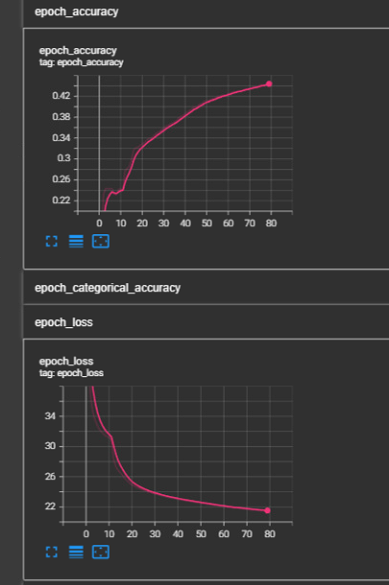

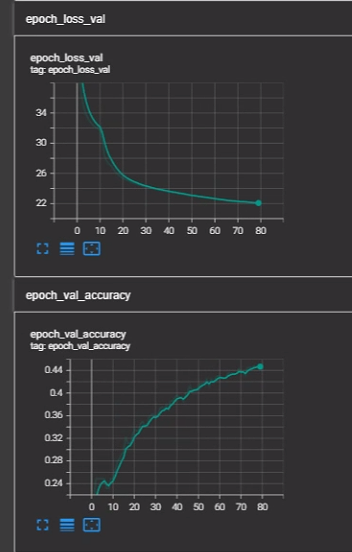

จากผลลัพธ์ที่ได้จาก tensorboard ของการทำ PoS with CRF pre-trainaed weight ค่า loss ของ train และ validation มีคล้ายกันและค่อนข้างคงที่ แต่ accuracy ยังคงเพิ่มขึ้นอยู่ แต่ก็เป็น accuary ที่ไม่สูงมากแสดงว่าโมเดลนี้ยังไม่สามารถทำนายคำที่ถูกต้องได้ดีเท่าที่ควร

### **Try tanh activation function**

In [40]:
def PosTagwithCRFPretainweight_tanh(name='POSTaggerwithCRFPretainweight_tanh',embedding_matrix=None):
    inputs = Input(shape=(102,), dtype='int32', name='inputLayer')
    if embedding_matrix is not None:
        output = (Embedding(num_words,
                            embedding_dim,
                            input_length=102,
                            mask_zero=True,
                            weights=[embedding_matrix],
                            trainable=False,
                            name='EmbeddingLayer'))(inputs)
    else:
        output = (Embedding(len(word_to_idx),embedding_dim,input_length=102,mask_zero=True,name='EmbeddingLayer'))(inputs)
    output = Bidirectional(GRU(32, return_sequences=True),name="BidirectionalLayer")(output)
    output = Dropout(0.2,name="DropoutLayer")(output)
    output = TimeDistributed(Dense(n_classes,activation='tanh'),name="TimeDistributedLayer")(output)
    
    crf = CRF(n_classes, dtype='float32',name="CRFLayer")
    output = crf(output)
    base_model = Model(inputs, output, name=name)
    base_model.summary()

    model = ModelWithCRFLoss(base_model, sparse_target=True)
    model.compile(optimizer=Adam(learning_rate=0.001))
    model.build(input_shape=(None,102))
    model._name = name
    return model

In [41]:
K.clear_session()

model_POS_CRF_Pretainweight_tanh = PosTagwithCRFPretainweight_tanh(name='POSTaggerwithCRFPretainweight_tanh',embedding_matrix=embedding_matrix)
config = POSConfig()
config.epochs = 40

his_pos_crf_pre =  model_train(x_train,y_train_pad,model_POS_CRF_Pretainweight_tanh,config,retrain=False)

Model: "POSTaggerwithCRFPretainweight_tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 102)]             0         
                                                                 
 EmbeddingLayer (Embedding)  (None, 102, 32)           480672    
                                                                 
 BidirectionalLayer (Bidirec  (None, 102, 64)          12672     
 tional)                                                         
                                                                 
 DropoutLayer (Dropout)      (None, 102, 64)           0         
                                                                 
 TimeDistributedLayer (TimeD  (None, 102, 48)          3120      
 istributed)                                                     
                                                                 
 CRFLayer (CRF)              ((N

### **TensorBoard Observation**

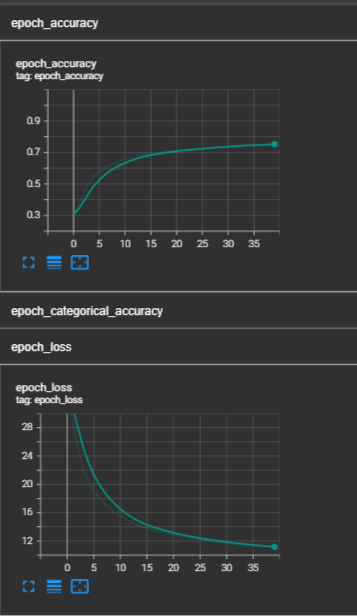

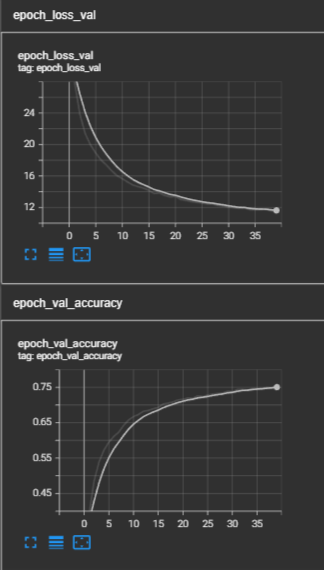

จากผลลัพธ์ที่ได้จาก tensorboard พบว่าค่า loss ที่ 40 epoches มีลักษณะเข้าใกล้ค่าคงที่เเล้ว เเละกราฟ loss ของ train กับ validate มีความคล้ายคลึงกัน คือลดลงเเละไม่เพิ่มขึ้น แสดงว่า model นี้เป็น Good Fitting (Ref. https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/)

### **Load Model**

In [42]:
model_POS_CRF_Pretainweight = load_model("tf_logs/POS/POSTaggerwithCRFPretainweight_tanh/POSTaggerwithCRFPretainweight_tanh")

### **Model Prediction**

In [43]:
his_pos_crf_pre_pred = get_y_pred(model_POS_CRF_Pretainweight,x_test)
df_his_pos_crf_pre = evaluation_report(y_test, his_pos_crf_pre_pred)

145/145 [==============================] - 18s 116ms/step


,tag,precision,recall,f_score,correct_count
0,1,98.600646,99.430122,99.013647,3664
1,2,81.213756,73.011639,76.894592,6022
2,3,63.909329,76.623838,69.691421,12941
3,4,71.070989,80.420987,75.45745,10392
4,5,100.0,83.58209,91.056911,56
5,6,79.661017,54.022989,64.383562,282
6,7,97.26232,93.987494,95.596869,1954
7,8,49.090909,19.518072,27.931034,81
8,9,48.763251,37.5,42.396313,138
9,10,28.571429,7.866508,12.336449,66


### **TODO 3**
Compare the result between all neural tagger models in 4.1 and 4.2.x and provide a convincing reason and example for the result of these models (which model perform better, why?)

(If you use your own weight please state so in the answer)

<b>Write your answer here :</b>

In [44]:
# Map tage to tag name
tagname = label_to_idx.keys()
temp = []
for key in tagname:
    dicttemp = {}
    dicttemp[key] = label_to_idx[key]
    temp.append(dicttemp)
# Reverse the dictionary
tagname = {v: k for d in temp for k, v in d.items()}
print(tagname)
df_npos['tag_name'] = df_npos['tag'].map(tagname)
df_npos = df_npos[['tag','tag_name', 'precision', 'recall', 'f_score', 'correct_count']]

{1: 'FIXN', 2: 'VACT', 3: 'NCMN', 4: 'PUNC', 5: 'CFQC', 6: 'DONM', 7: 'JCRG', 8: 'NCNM', 9: 'CNIT', 10: 'NPRP', 11: 'NTTL', 12: 'XVAM', 13: 'VSTA', 14: 'RPRE', 15: 'ADVN', 16: 'JSBR', 17: 'DDAC', 18: 'XVBM', 19: 'XVMM', 20: 'DIBQ', 21: 'PREL', 22: 'VATT', 23: 'XVAE', 24: 'DCNM', 25: 'CMTR', 26: 'FIXV', 27: 'PPRS', 28: 'XVBB', 29: 'DIAC', 30: 'PDMN', 31: 'DDAN', 32: 'CLTV', 33: 'ADVP', 34: 'NLBL', 35: 'ADVI', 36: 'CMTR@PUNC', 37: 'JCMP', 38: 'ADVS', 39: 'DDBQ', 40: 'NEG', 41: 'PNTR', 42: 'EITT', 43: 'DDAQ', 44: 'NONM', 45: 'EAFF', 46: 'DIAQ', 47: 'CVBL'}


In [45]:
df_his_pos_crf = df_his_pos_crf.drop(['tag'],axis=1)
df_his_pos_crf_pre = df_his_pos_crf_pre.drop(['tag'],axis=1)

df_mixed = pd.concat([df_npos,df_his_pos_crf,df_his_pos_crf_pre], axis=1)

In [46]:
df_mixed

,tag,tag_name,precision,recall,f_score,correct_count,precision,recall,f_score,correct_count,precision,recall,f_score,correct_count
0,1,FIXN,99.891127,99.592944,99.741813,3670,99.863946,99.592944,99.728261,3670,98.600646,99.430122,99.013647,3664
1,2,VACT,93.411821,95.235209,94.314703,7855,93.559928,95.113967,94.330548,7845,81.213756,73.011639,76.894592,6022
2,3,NCMN,91.337421,95.26911,93.261846,16090,91.035644,96.027,93.46473,16218,63.909329,76.623838,69.691421,12941
3,4,PUNC,99.984464,99.605324,99.794534,12871,99.868064,99.582108,99.724881,12868,71.070989,80.420987,75.45745,10392
4,5,CFQC,88.0,98.507463,92.957746,66,95.652174,98.507463,97.058824,66,100.0,83.58209,91.056911,56
5,6,DONM,99.781659,87.547893,93.265306,457,99.56427,87.547893,93.170234,457,79.661017,54.022989,64.383562,282
6,7,JCRG,97.722868,97.017797,97.369056,2017,97.220891,97.594998,97.407585,2029,97.26232,93.987494,95.596869,1954
7,8,NCNM,59.852217,58.554217,59.196102,243,61.038961,56.626506,58.75,235,49.090909,19.518072,27.931034,81
8,9,CNIT,76.510067,61.956522,68.468468,228,74.832215,60.597826,66.966967,223,48.763251,37.5,42.396313,138
9,10,NPRP,61.862917,41.954708,50.0,352,61.929825,42.073897,50.106458,353,28.571429,7.866508,12.336449,66


In [47]:
# %load_ext tensorboard
# %tensorboard --logdir='tf_logs/POS/'

โดยผลลัพท์จากการเปรียบเทียบทั้ง 3 โมเดลจะสั่งเกตได้ว่า

ผลลัพธ์ของโมเดลแต่ละ model สามารถเรียงลำดับได้ดังนี้

1. โมเดล Neural POS Tagger (accuracy = 0.9297)
2. โมเดล Neural POS Tagger with CRF (accuracy = 0.9019)
3. โมเดล Neural POS Tagger with CRF pre-trainaed weight (accuracy = 0.4577)

โดยเหตุผลที่ทำให้เกิดผลลัพธ์นี้เกิดขึ้นจะสามารถแบ่งเป็น 2 ส่วนได้ดังนี้

1. Performance ของโมเดลที่ใช้ pre-trainaed weight ทำไมถึงแย่กว่าโมเดลแื่น ๆ อย่างเห็นได้ชัด

    โมเดล POS with CRF pre-trainaed weight มีค่า accuracy ที่ต่ำกว่าโมเดลอื่น ๆ อย่างเห็นได้ชัด ทั้งนี้เหตุผลจะเกี่ยวข้องกับการทำ embedding matirx ของคำศัพท์ที่ไม่มีใน corpus ที่ใช้ในการ train โมเดลทำให้โมเดลที่ใช้ embedding ไม่สามารถทำนายคำที่ไม่มีใน corpus ได้ดี และจะทำให้มีค่า accuracy ต่ำกว่าโมเดลอื่น ๆ อีก (จากผลลัทธ์ในการรัน rom dict embeddings_basic_ff, found embeddings for 5158 words (34.34%) and 9861 (65.65%) not found.)

โดย Tag ที่พบเห็น

- CFQC : NOUN (Frequency classifier)
- DONM : ADJ (Ordinal number expression)
- NCNM : NUM (Cardinal number)
- CNIT : NOUN (Unit classifier)
- NPRP : PROPN (Proper noun)
- DIBQ : Indefinite determiner (บาง, ประมาณ, เกือบ)
- VATT : ADJ (Attributive verb)
- DCNM : NUM (Determiner, Cardinal number expression)
- CMTR : NOUN (Measurement classifier)
- FIXV : PART (Adverbial prefix)
- PPRS : PRON (Personal pronoun)
- CLTV : NOUN (Collective classifier)
- ADVP : ADV (Adverb with prefixed form)
- NLBL : NUM (Label noun)
- ADVI : ADV (Adverb with iterative form)
- JCMP : SCONJ (Comparative conjunction)
- ADVS : ADV (Sentential adverb)
- PNTR : PRON (Interrogative pronoun)
- EITT : PART (Ending for interrogative sentence)
- DDAQ : DET (Definite determiner)
- NONM : ADJ (Ordinal number)
- EAFF : PART (Ending for affirmative sentence)
- DIAQ : DET (Indefinite determiner)

## Get Wrong Prediction Function

To get wrong prediction word from y_pred.

In [48]:
# get wrong prediction

def get_wrong_pred(y_true,y_pred):
    wrong_pred = []
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            wrong_pred.append(i)
    return wrong_pred

To get wrong word prediction from y_pred.

In [49]:
# get wrong prediction

def get_wrong_pred(x_true,y_true,y_pred,y_pred1,y_pred2):
    
    # remove padding
    x_true_new = []
    for i in range(len(x_true)):
        data = x_true[i]
        temp = []
        for j in range(len(data)):
            if data[j] != 0:
                temp.append(data[j])
        x_true_new.append(temp)
                
    wrong_pred = []
    for i in range(len(y_true)):
        tempdict = {}
        if not np.array_equal(y_true[i],y_pred[i]) or not np.array_equal(y_true[i],y_pred1[i]) or not np.array_equal(y_true[i],y_pred2[i]):
            tempdict['index'] = i
            tempdict['sentence'] = x_true_new[i]
            tempdict['true'] = y_true[i]
            tempdict['npos'] = y_pred[i]
            tempdict['crf'] = y_pred1[i]
            tempdict['crfwpret'] = y_pred2[i]
            wrong_pred.append(tempdict)
    return wrong_pred

def idx_to_word(idx):
    for word, index in word_to_idx.items(): 
        if index == idx: 
            return word
    return None

def idx_to_label(idx):
    for label, index in label_to_idx.items(): 
        if index == idx:
            return label
    return None

def decode_wrong_pred(wrong_pred):
    temp = []
    for i in range(len(wrong_pred)):
        tempdict = {}
        tempdict['index'] = wrong_pred[i]['index']
        tempdict['sentence'] = [idx_to_word(idx) for idx in wrong_pred[i]['sentence']]
        tempdict['true'] = [idx_to_label(idx) for idx in wrong_pred[i]['true']]
        tempdict['npos'] = [idx_to_label(idx) for idx in wrong_pred[i]['npos']]
        tempdict['crf'] = [idx_to_label(idx) for idx in wrong_pred[i]['crf']]
        tempdict['crfwpret'] = [idx_to_label(idx) for idx in wrong_pred[i]['crfwpret']]
        temp.append(tempdict)
    return temp

def random_print_sample(wrong_pred, random_unit=1000):
    for i in range(random_unit):
        random_index = np.random.randint(0,len(wrong_pred))
        temp_sentence = '/'.join(wrong_pred[random_index]['sentence'])
        temp_true = '/'.join(wrong_pred[random_index]['true'])
        temp_npos = '/'.join(wrong_pred[random_index]['npos'])
        temp_crf = '/'.join(wrong_pred[random_index]['crf'])
        temp_crfwpret = '/'.join(wrong_pred[random_index]['crfwpret'])
        print(f'sentence: {temp_sentence}')
        print(f'true    : {temp_true}')
        print(f'npos    : {temp_npos}')
        print(f'crf     : {temp_crf}')
        print(f'crfwpret: {temp_crfwpret}')
        print('======================================================================')

In [50]:
wrong_pred = get_wrong_pred(x_test, y_test, ypred, his_pos_crf_pred, his_pos_crf_pre_pred)
print(wrong_pred[1])

{'index': 3, 'sentence': [10, 1, 5832, 1258, 1, 601, 517, 38, 1763, 96, 122, 35, 1625, 63, 207], 'true': array([ 7,  1,  2,  2,  1,  2,  3, 14,  3, 16, 13, 14,  3, 21,  2]), 'npos': [7, 1, 2, 2, 1, 2, 3, 14, 3, 16, 13, 14, 3, 21, 2], 'crf': array([ 7.,  1.,  2.,  2.,  1.,  2.,  3., 14.,  3., 16., 13., 14.,  3.,
       21.,  2.]), 'crfwpret': array([ 7.,  1.,  2.,  2.,  1.,  2.,  3., 14.,  3., 16., 13., 14.,  3.,
       21., 22.])}


In [51]:
output_wrong = decode_wrong_pred(wrong_pred)

In [52]:
random_print_sample(output_wrong, 100)

sentence: คอมพิวเตอร์/DATABAS 2/เชิง/DATABAS 2/นั้น/<space>/<left_parenthesis>/<space>/DATABAS 2/<space>/<right_parenthesis>/<space>/หมายถึง/<space>/การ/เชื่อมโยง/<space>/และ/รวบรวม/ข้อมูล/ต่างๆ/<space>/เข้าด้วยกัน
true    : NCMN/NCMN/NCMN/NCMN/DDAC/PUNC/PUNC/PUNC/NCMN/PUNC/PUNC/PUNC/VSTA/PUNC/FIXN/VACT/PUNC/JCRG/VACT/NCMN/DIAC/PUNC/ADVN
npos    : NCMN/NCMN/NCMN/NCMN/DDAC/PUNC/PUNC/PUNC/NCMN/PUNC/PUNC/PUNC/VSTA/PUNC/FIXN/VACT/PUNC/JCRG/VACT/NCMN/DIAC/PUNC/ADVN
crf     : NCMN/NCMN/NCMN/NCMN/DDAC/PUNC/PUNC/PUNC/NCMN/PUNC/PUNC/PUNC/VSTA/PUNC/FIXN/VACT/PUNC/JCRG/VACT/NCMN/DIAC/PUNC/ADVN
crfwpret: NCMN/NCMN/RPRE/NCMN/DDAC/PUNC/NCMN/PUNC/NCMN/PUNC/PUNC/NCMN/PUNC/PUNC/FIXN/VACT/NCMN/JCRG/VACT/NCMN/DIAC/PUNC/NCMN
sentence: โดย/มักจะ/คิด/ว่า/ยัง/ไม่/ถึง/เวลา
true    : JSBR/XVBM/VACT/JSBR/XVBM/NEG/VSTA/NCMN
npos    : JSBR/XVBM/VACT/JSBR/XVBM/NEG/RPRE/NCMN
crf     : JSBR/XVBM/VACT/JSBR/XVBM/NEG/RPRE/NCMN
crfwpret: JSBR/VACT/NCMN/JSBR/XVBM/NEG/VATT/ADVN
sentence: ต้นแบบ/DATABAS 2/DATABAS 2/แนวดิ่ง

- Model Accuracy : NPoS(91.81) > PoSWithCRF No Pretrain(86.56) > PoSWithCRF With Pretrain(86.31) (60 Epoches)
- สาเหตุที่ PoS With CRF ที่ทำการ Pretrain weight เเล้ว มีความเเม่นยำน้อยกว่าเเบบไม่ได้ Pretrain weight เนื่องจาก *** มี hits 5158 คำ เเละ misses ทั้งหมด 9861 คำ